In [1]:
import pandas as pd
#data = pd.read_excel('Pivot_WithoutNA_L.xlsx')
data = pd.read_excel('220615_Final clustering Data_updated.xlsx')

data.head()

,Company,Ticker,Parameters,Years,Value,Unit
0,3M Company,NYSE:MMM,Avg. Cash Conversion Cycle,CY2017,97.3123,Days
1,3M Company,NYSE:MMM,Avg. Cash Conversion Cycle,CY2018,102.119,Days
2,3M Company,NYSE:MMM,Avg. Cash Conversion Cycle,CY2019,97.8985,Days
3,3M Company,NYSE:MMM,Avg. Cash Conversion Cycle,CY2020,94.0825,Days
4,3M Company,NYSE:MMM,Avg. Cash Conversion Cycle,CY2016,92.856,Days


In [2]:
data_20 = data[data['Years']==2020]

In [3]:
data_20 = data_20[["Company","Years","Asia Pacific","Australasia","Avg. Cash Conversion Cycle","Baby and Child-specific Products",
                   "Cash & Equivalents","Cash from Financing","Cash from Investing","China","Colour Cosmetics",
                   "Cost of Goods Sold","Current Ratio","Deodorants","Depilatories","Diluted EPS","Dividend per Share",
                   "Europe","Inventory","Latin America","Men's Grooming","Middle East and Africa","Net Debt",
                   "Net Debt/(EBITDA-Capex)","Net Income to the Company","Net Interest Expense","Net Rental Expense",
                   "Normalised Diluted EPS","North America","Operating Income","Oral Care","Payout Ratio","R&D Expense",
                   "Return on Capital","Skin Care","Sun Care","Total Assets turnover","Total Debt/Capital","Total Liabilities"]]

In [4]:
pca_df = data_20.iloc[:,2:]

In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(pca_df)
scaled_data = pd.DataFrame(scaled_df,columns = data_20.columns[2:])

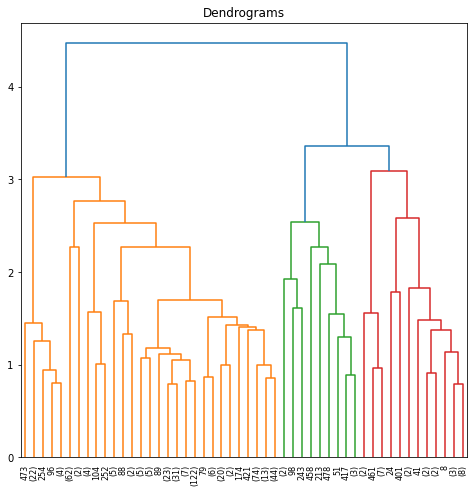

In [6]:
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(scaled_data, method='ward'),truncate_mode='lastp',p=50)

In [7]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestCentroid
from scipy.spatial.distance import cdist

model = AgglomerativeClustering(n_clusters = 6).fit(scaled_data)
ypredict = model.fit_predict(scaled_data)

clf = NearestCentroid()
clf.fit(scaled_data, ypredict)

dists = cdist(scaled_data,clf.centroids_,metric='euclidean')
Hierarchical_Distance_Matrix = pd.DataFrame(dists,columns=['Hierarchical_Dist_'+str(i) for i in range(6)])

inside pyplot file


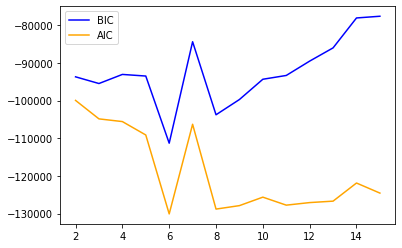

In [8]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture as GMM
import matplotlib.pyplot as plt

# b=PCA_components.values.reshape(-1,1)
# b=np.log(b)
####### finding best n_components ########
k= np.arange(2,16,1)
# GMM(2,covariance_type='full').fit(b)
clfs= [GMM(n,covariance_type='full').fit(scaled_data) for n in k]
aics= [clf.aic(scaled_data) for clf in clfs]
bics= [clf.bic(scaled_data) for clf in clfs]
plt.plot(k,bics,color='b',label='BIC')
plt.plot(k,aics,color='orange',label='AIC')
# plt.xticks(list(range(3,20,1)))
plt.legend()
plt.show()

In [9]:
from sklearn.mixture import GaussianMixture
model = GaussianMixture(n_components=6,
                         init_params='kmeans',n_init=100,
                         random_state=1 # for reproducibility
                        )
labels = model.fit_predict(scaled_data)   
# from collections import defaultdict
# counter = defaultdict(int)
# for letter in labels:
#     counter[letter] += 1
# counter
yprobs = model.predict_proba(scaled_data)
GMM_Probabilities = pd.DataFrame(yprobs,columns=['GMM_Prob_'+str(i) for i in range(6)])

In [10]:
from fcmeans import FCM
from sklearn import metrics
metric = []
for m in [1.25,1.5,1.75,2,2.25,2.5,2.75,3,4,5]:
    for i in range(2,15):
        mylist = []
        model = FCM(n_clusters=i,m=m,random_state=0)
        model.fit(scaled_data.values)
        centers = model.centers
        labels = model.predict(scaled_data.values)
#         print("Silhouette score: {}".format(metrics.silhouette_score(new_scaled_data, labels,metric='euclidean')))
#         print("Davies Bouldin score: {}".format(metrics.davies_bouldin_score(new_scaled_data, labels)))
#         print("Calinski Harabasz score: {}".format(metrics.calinski_harabasz_score(new_scaled_data, labels)))
        mylist.append(m)
        mylist.append(i)
        mylist.append(metrics.silhouette_score(scaled_data, labels,metric='euclidean'))
        mylist.append(model.partition_coefficient)
        mylist.append(model.partition_entropy_coefficient)
        mylist.append(metrics.davies_bouldin_score(scaled_data, labels))
        mylist.append(metrics.calinski_harabasz_score(scaled_data, labels))
#         print(model.partition_coefficient)
#         print(model.partition_entropy_coefficient)
#         print(model.partition_coefficient - model.partition_entropy_coefficient)
#         print('M:I:S- ',m,i,metrics.silhouette_score(new_scaled_data, labels, metric='euclidean'))
#         print('****************************************')
        metric.append(mylist)

metric_df = pd.DataFrame(metric,columns=['Fuzzy','Cluster_nos','silhouette_score','partition_coefficient','partition_entropy_coefficient',
                            'davies_bouldin_score','calinski_harabasz_score'])
metric_df[(metric_df['Cluster_nos']>2) & (
    metric_df['partition_coefficient']> metric_df['partition_entropy_coefficient'])].sort_values(
    by=['silhouette_score','partition_coefficient'],ascending=False).head(50)

,Fuzzy,Cluster_nos,silhouette_score,partition_coefficient,partition_entropy_coefficient,davies_bouldin_score,calinski_harabasz_score
2,1.25,4,0.185353,0.195935,0.138735,1.793363,47.099028
1,1.25,3,0.155761,0.266452,0.159051,1.959925,56.555090
5,1.25,7,0.154097,0.104480,0.103316,1.991136,45.704725


In [11]:
metric_df[(metric_df['Cluster_nos']>2)].sort_values(
    by=['silhouette_score','partition_coefficient'],ascending=False).head(10)

,Fuzzy,Cluster_nos,silhouette_score,partition_coefficient,partition_entropy_coefficient,davies_bouldin_score,calinski_harabasz_score
2,1.25,4,0.185353,0.195935,0.138735,1.793363,47.099028
15,1.50,4,0.175800,0.152986,0.255775,1.874897,46.526177
11,1.25,13,0.155781,0.051841,0.075426,1.705016,34.799724
1,1.25,3,0.155761,0.266452,0.159051,1.959925,56.555090
5,1.25,7,0.154097,0.104480,0.103316,1.991136,45.704725
9,1.25,11,0.149898,0.062460,0.086372,1.946200,33.080859
4,1.25,6,0.149467,0.120064,0.124600,2.197442,41.068974
6,1.25,8,0.148547,0.087870,0.105206,1.988466,41.206484
7,1.25,9,0.144064,0.076798,0.100868,1.986720,38.752700
66,2.50,3,0.142201,0.111111,0.528321,2.599983,34.444815


In [12]:
from fcmeans import FCM

model = FCM(n_clusters=4,m=1.25)
model.fit(scaled_data.values)

centers = model.centers
labels = model.predict(scaled_data.values)
yprobs = model.soft_predict(scaled_data.values)

FCM_Probabilities = pd.DataFrame(yprobs,columns=['FCM_Prob_'+str(i) for i in range(4)])

In [13]:
new_data = pd.concat([Hierarchical_Distance_Matrix,GMM_Probabilities,FCM_Probabilities],axis=1)

In [14]:
new_data.head()

,Hierarchical_Dist_0,Hierarchical_Dist_1,Hierarchical_Dist_2,Hierarchical_Dist_3,Hierarchical_Dist_4,Hierarchical_Dist_5,GMM_Prob_0,GMM_Prob_1,GMM_Prob_2,GMM_Prob_3,GMM_Prob_4,GMM_Prob_5,FCM_Prob_0,FCM_Prob_1,FCM_Prob_2,FCM_Prob_3
0,0.551481,0.671234,0.904475,0.409129,0.755706,0.740037,0.000000e+00,1.000000e+00,9.121035e-212,0.0,3.160258e-123,0.0,0.000837,0.001120,9.969036e-01,0.001140
1,0.635039,0.181035,0.834726,0.838639,0.282622,0.381575,1.000000e+00,4.571799e-66,1.517840e-18,0.0,4.011085e-30,0.0,0.002129,0.211365,1.614983e-05,0.786490
2,0.566402,0.184049,0.804724,0.729163,0.318430,0.406621,8.414428e-35,5.932753e-22,1.000000e+00,0.0,1.143333e-14,0.0,0.002626,0.275745,1.322599e-04,0.721497
3,0.608314,0.089010,0.818498,0.804779,0.352001,0.325209,1.000000e+00,4.881049e-38,1.602924e-15,0.0,2.944733e-26,0.0,0.000162,0.996892,3.009311e-07,0.002946
4,0.682496,0.336491,0.841186,0.896329,0.604147,0.307520,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.518437e-218,0.0,0.802632,0.177133,1.087520e-03,0.019147


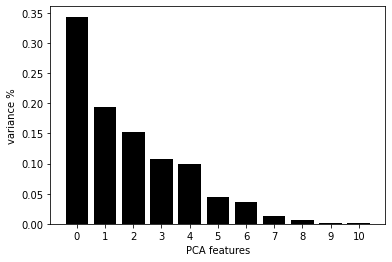

In [15]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(new_data)
new_scaled_data = pd.DataFrame(scaled_df,columns = new_data.columns)


from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Create a PCA instance: pca
pca = PCA(n_components=11)
principalComponents = pca.fit_transform(new_scaled_data)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

In [16]:
new_scaled_data.head()

,Hierarchical_Dist_0,Hierarchical_Dist_1,Hierarchical_Dist_2,Hierarchical_Dist_3,Hierarchical_Dist_4,Hierarchical_Dist_5,GMM_Prob_0,GMM_Prob_1,GMM_Prob_2,GMM_Prob_3,GMM_Prob_4,GMM_Prob_5,FCM_Prob_0,FCM_Prob_1,FCM_Prob_2,FCM_Prob_3
0,0.132998,0.305530,0.295179,0.121755,0.322400,0.336445,0.000000e+00,1.000000e+00,9.121035e-212,0.0,3.160258e-123,0.0,0.000832,0.001095,1.000000e+00,0.001140
1,0.186202,0.065425,0.252695,0.332345,0.081955,0.164906,1.000000e+00,4.571799e-66,1.517840e-18,0.0,4.011085e-30,0.0,0.002125,0.211346,1.619891e-05,0.786897
2,0.142499,0.066902,0.234420,0.278669,0.100154,0.176891,8.414428e-35,5.932753e-22,1.000000e+00,0.0,1.143333e-14,0.0,0.002622,0.275729,1.326696e-04,0.721870
3,0.169186,0.020351,0.242810,0.315743,0.117217,0.137933,1.000000e+00,4.881049e-38,1.602924e-15,0.0,2.944733e-26,0.0,0.000158,0.996898,3.007770e-07,0.002947
4,0.216420,0.141569,0.256630,0.360630,0.245370,0.129468,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.518437e-218,0.0,0.802652,0.177113,1.090896e-03,0.019157


In [17]:
import numpy as np
np.cumsum(pca.explained_variance_ratio_)

array([0.34354769, 0.53689491, 0.68908629, 0.79710398, 0.89648737,
       0.94069703, 0.97686897, 0.99059002, 0.99699749, 0.99854174,
       0.99910702])

For n_clusters = 2 The average silhouette_score is : 0.37907372769155984
For n_clusters = 3 The average silhouette_score is : 0.47702132597132896
For n_clusters = 4 The average silhouette_score is : 0.5378304854473623
For n_clusters = 5 The average silhouette_score is : 0.5904635716273094
For n_clusters = 6 The average silhouette_score is : 0.6492131711919067
For n_clusters = 7 The average silhouette_score is : 0.7046567910727171
For n_clusters = 8 The average silhouette_score is : 0.7191247183619474
For n_clusters = 9 The average silhouette_score is : 0.7017148183872175
For n_clusters = 10 The average silhouette_score is : 0.6872905739211536
For n_clusters = 11 The average silhouette_score is : 0.6919244922185166
For n_clusters = 12 The average silhouette_score is : 0.703731726058852
For n_clusters = 13 The average silhouette_score is : 0.6950934211958448
For n_clusters = 14 The average silhouette_score is : 0.6962756213260303
For n_clusters = 15 The average silhouette_score is : 0.65

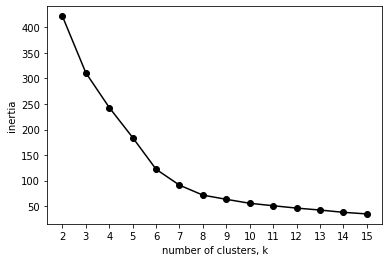

In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import matplotlib.style as style

range_n_clusters = list(range(2,16))
silhouette_avg_n_clusters = []
inertias = []

for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=0,init='k-means++')
    cluster_labels = clusterer.fit_predict(new_scaled_data)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(new_scaled_data, cluster_labels)
    inertias.append(clusterer.inertia_)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
plt.plot(range_n_clusters, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(range_n_clusters)
plt.show()

For n_clusters = 8 The average silhouette_score is : 0.7191247294831211

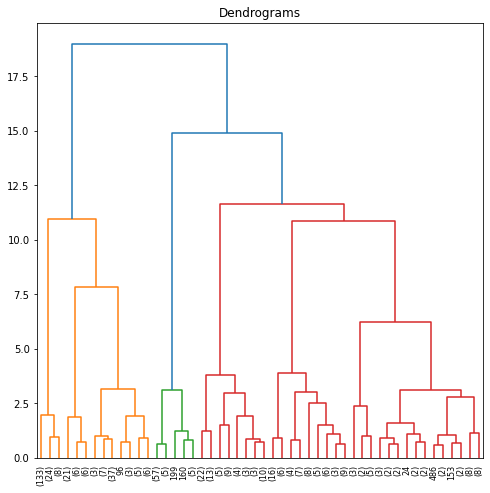

In [19]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(8, 8))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(new_scaled_data, method='ward'),truncate_mode='lastp',p=50)

inside pyplot file


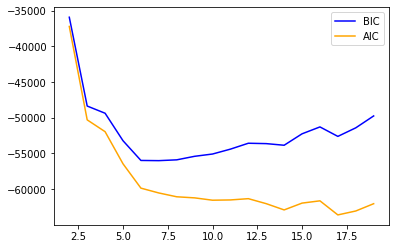

In [20]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture as GMM
import matplotlib.pyplot as plt

# b=PCA_components.values.reshape(-1,1)
# b=np.log(b)
####### finding best n_components ########
k= np.arange(2,20,1)
# GMM(2,covariance_type='full').fit(b)
clfs= [GMM(n,covariance_type='full').fit(new_scaled_data) for n in k]
aics= [clf.aic(new_scaled_data) for clf in clfs]
bics= [clf.bic(new_scaled_data) for clf in clfs]
plt.plot(k,bics,color='b',label='BIC')
plt.plot(k,aics,color='orange',label='AIC')
# plt.xticks(list(range(3,20,1)))
plt.legend()
plt.show()

In [21]:
from fcmeans import FCM
from sklearn import metrics
metric = []
for m in [1.25,1.5,1.75,2,2.25,2.5,2.75,3,4,5]:
    for i in range(2,15):
        mylist = []
        model = FCM(n_clusters=i,m=m,random_state=0)
        model.fit(new_scaled_data.values)
        centers = model.centers
        labels = model.predict(new_scaled_data.values)
#         print("Silhouette score: {}".format(metrics.silhouette_score(new_scaled_data, labels,metric='euclidean')))
#         print("Davies Bouldin score: {}".format(metrics.davies_bouldin_score(new_scaled_data, labels)))
#         print("Calinski Harabasz score: {}".format(metrics.calinski_harabasz_score(new_scaled_data, labels)))
        mylist.append(m)
        mylist.append(i)
        mylist.append(metrics.silhouette_score(new_scaled_data, labels,metric='euclidean'))
        mylist.append(model.partition_coefficient)
        mylist.append(model.partition_entropy_coefficient)
        mylist.append(metrics.davies_bouldin_score(new_scaled_data, labels))
        mylist.append(metrics.calinski_harabasz_score(new_scaled_data, labels))
#         print(model.partition_coefficient)
#         print(model.partition_entropy_coefficient)
#         print(model.partition_coefficient - model.partition_entropy_coefficient)
#         print('M:I:S- ',m,i,metrics.silhouette_score(new_scaled_data, labels, metric='euclidean'))
#         print('****************************************')
        metric.append(mylist)

In [22]:
metric_df = pd.DataFrame(metric,columns=['Fuzzy','Cluster_nos','silhouette_score','partition_coefficient','partition_entropy_coefficient',
                            'davies_bouldin_score','calinski_harabasz_score'])

In [23]:
metric_df[metric_df['Cluster_nos']>2].sort_values(by=['silhouette_score','partition_coefficient'],ascending=False).head(10)

,Fuzzy,Cluster_nos,silhouette_score,partition_coefficient,partition_entropy_coefficient,davies_bouldin_score,calinski_harabasz_score
6,1.25,8,0.719125,0.122650,0.007826,0.579704,527.640765
8,1.25,10,0.708319,0.097712,0.007117,0.637752,507.307846
7,1.25,9,0.704563,0.108411,0.008345,0.660502,524.538982
20,1.50,9,0.703908,0.100836,0.035401,0.661919,524.323258
5,1.25,7,0.703747,0.138555,0.014033,0.716644,464.387110
18,1.50,7,0.702564,0.129920,0.044181,0.691528,460.793516
31,1.75,7,0.702564,0.118624,0.083338,0.691528,460.793516
44,2.00,7,0.702564,0.106850,0.123377,0.691528,460.793516
57,2.25,7,0.702564,0.095802,0.160238,0.691528,460.793516
70,2.50,7,0.702142,0.085883,0.192627,0.691035,460.483048


In [24]:
metric_df[(metric_df['Cluster_nos']>2) & (
    metric_df['partition_coefficient']> metric_df['partition_entropy_coefficient'])].sort_values(
    by=['silhouette_score','partition_coefficient'],ascending=False).head(10)

,Fuzzy,Cluster_nos,silhouette_score,partition_coefficient,partition_entropy_coefficient,davies_bouldin_score,calinski_harabasz_score
6,1.25,8,0.719125,0.122650,0.007826,0.579704,527.640765
8,1.25,10,0.708319,0.097712,0.007117,0.637752,507.307846
7,1.25,9,0.704563,0.108411,0.008345,0.660502,524.538982
20,1.50,9,0.703908,0.100836,0.035401,0.661919,524.323258
5,1.25,7,0.703747,0.138555,0.014033,0.716644,464.387110
18,1.50,7,0.702564,0.129920,0.044181,0.691528,460.793516
31,1.75,7,0.702564,0.118624,0.083338,0.691528,460.793516
33,1.75,9,0.699183,0.091230,0.070610,0.714151,520.888796
22,1.50,11,0.691182,0.082281,0.029483,0.694422,536.757720
38,1.75,14,0.690369,0.059224,0.046111,0.700235,540.030844


davies_bouldin_score(X, labels)- Compute the Davies-Bouldin score. The score is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances. Lower Better

calinski_harabasz_score - The score is defined as ratio of the sum of between-cluster dispersion and of within-cluster dispersion. Higher Better

In [25]:
from fcmeans import FCM
from sklearn import metrics
model = FCM(n_clusters=7,m=1.25)
model.fit(new_scaled_data.values)
centers = model.centers
labels = model.predict(new_scaled_data.values)
print(model.partition_coefficient)
print(model.partition_entropy_coefficient)

0.1385548245307005
0.014032988498669761


In [26]:
from collections import defaultdict
counter = defaultdict(int)
for letter in labels:
    counter[letter] += 1
dict(counter)

{1: 43, 3: 57, 6: 69, 2: 170, 4: 69, 5: 65, 0: 33}

In [27]:
data_20['Cluster_Ids'] = labels

In [28]:
data_20.head()

,Company,Years,Asia Pacific,Australasia,Avg. Cash Conversion Cycle,Baby and Child-specific Products,Cash & Equivalents,Cash from Financing,Cash from Investing,China,...,Oral Care,Payout Ratio,R&D Expense,Return on Capital,Skin Care,Sun Care,Total Assets turnover,Total Debt/Capital,Total Liabilities,Cluster_Ids
4,3M Company,2020,0.82141,0.0,94.08250,0.0,4634.00000,-5300.00000,-580.00000,0.0,...,0.000000,62.1765,0.058352,13.9480,0.82141,0.0,0.69963,60.4629,34413.00000,1
9,4mass Spólka Akcyjna (WSE:4MS),2020,0.00000,0.0,301.32451,0.0,0.35736,2.17243,-0.80789,0.0,...,0.000000,0.0000,0.000000,8.1377,0.00000,0.0,1.34233,9.9681,2.83924,3
14,AB Electrolux (publ),2020,0.00000,0.0,-9.72133,0.0,2459.11220,391.95297,-633.40769,0.0,...,0.071399,30.5589,0.033753,9.7768,0.00000,0.0,1.12358,49.4187,9849.84265,6
19,"AFC-HD AMS Life Science Co., Ltd. (TSE:2927)",2020,0.00000,0.0,72.76666,0.0,52.66916,0.00000,0.00000,0.0,...,0.000000,0.0000,0.009998,6.0801,0.00000,0.0,0.87217,27.1081,84.78239,2
24,ALBIS Leasing AG,2020,0.00000,0.0,0.00000,0.0,12.50520,-1.19266,-0.36086,0.0,...,4.210667,72.3196,0.000000,2.0483,0.00000,0.0,0.11370,88.4973,250.61284,4


In [29]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(scaled_data, data_20.iloc[:,-1], test_size=0.2, random_state=0,stratify=data_20.iloc[:,-1].values)

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
dtc = DecisionTreeClassifier()
grid = { 
    'criterion': {'gini', 'entropy', 'log_loss'},
    'max_features': ['sqrt', 'log2','auto'],
    'max_depth' : list(range(5,11)),
    'min_samples_split': list(range(4,11)),
    'min_samples_leaf': list(range(4,11)),
    'criterion' :['gini', 'entropy'],
    'max_leaf_nodes': list(range(5,18)),
    'random_state' : [0]
}
dtc_cv = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=grid, cv= 5)
dtc_cv.fit(xtrain, ytrain)
dtc_cv.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'sqrt',
 'max_leaf_nodes': 17,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'random_state': 0}

              precision    recall  f1-score   support

           0       0.50      0.14      0.22         7
           1       0.62      0.56      0.59         9
           2       0.66      0.85      0.74        34
           3       0.56      0.45      0.50        11
           4       0.87      0.93      0.90        14
           5       0.40      0.15      0.22        13
           6       0.21      0.29      0.24        14

    accuracy                           0.58       102
   macro avg       0.55      0.48      0.49       102
weighted avg       0.57      0.58      0.55       102

F1 Score:  0.553590950053186
ROC AUC Score:  0.7912336184785377


,0,1,2,3,4,5,6
0,1,0,3,0,1,0,2
1,0,5,0,0,0,2,2
2,1,0,29,0,0,1,3
3,0,0,4,5,0,0,2
4,0,0,1,0,13,0,0
5,0,0,1,3,1,2,6
6,0,3,6,1,0,0,4


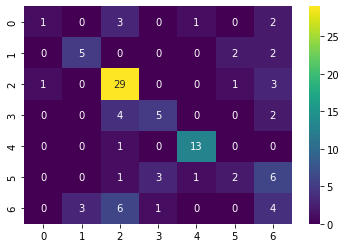

In [31]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(criterion= 'gini',
                             max_depth = 9,
                             max_features = 'sqrt',
                             max_leaf_nodes = 16,
                             min_samples_leaf = 10,
                             min_samples_split = 4,
                             random_state= 0
                             )
dtc.fit(xtrain,ytrain)
ypredict = dtc.predict(xtest)

from sklearn.metrics import classification_report,confusion_matrix,f1_score,roc_auc_score
import seaborn as sns
print(classification_report(ytest,ypredict))
print("F1 Score: ",f1_score(ytest,ypredict,average='weighted'))
# Generate class membership probabilities
y_preb_probs = dtc.predict_proba(xtest)

print('ROC AUC Score: ',roc_auc_score(ytest, y_preb_probs, average="weighted", multi_class="ovr"))

sns.heatmap(confusion_matrix(ytest,ypredict),cmap='viridis',annot=True)
pd.DataFrame(confusion_matrix(ytest,ypredict))

              precision    recall  f1-score   support

           0       0.60      0.23      0.33        26
           1       0.71      0.44      0.55        34
           2       0.71      0.87      0.78       136
           3       0.76      0.74      0.75        46
           4       0.91      0.91      0.91        55
           5       0.56      0.44      0.49        52
           6       0.49      0.58      0.53        55

    accuracy                           0.69       404
   macro avg       0.68      0.60      0.62       404
weighted avg       0.69      0.69      0.67       404

F1 Score:  0.6746705538759448
ROC AUC Score:  0.909843301403437


<AxesSubplot:>

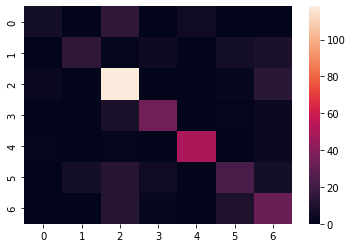

In [33]:
ypredict = dtc.predict(xtrain)

from sklearn.metrics import classification_report,confusion_matrix,f1_score,roc_auc_score
import seaborn as sns
print(classification_report(ytrain,ypredict))
print("F1 Score: ",f1_score(ytrain,ypredict,average='weighted'))
# Generate class membership probabilities
y_preb_probs = dtc.predict_proba(xtrain)

print('ROC AUC Score: ',roc_auc_score(ytrain, y_preb_probs, average="weighted", multi_class="ovr"))

sns.heatmap(confusion_matrix(ytrain,ypredict))

In [ ]:
data_20.to_excel('cluster_2020.xlsx',index=False)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import model_selection, metrics
#from sklearn.grid_search import GridSearchCV

#Grid seach on subsample and max_features
param_test2 = {'max_depth':range(2,16,2), 'min_samples_split':range(200,1001,200), 'min_samples_leaf':range(5,50,5),
              'n_estimators':range(10,500,20), 'learning_rate' :[0.01,0.05, 0.1]}

#xtrain, xtest, ytrain, ytest
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(max_features='sqrt'), 
                       param_grid = param_test2, cv = 10)

gsearch2.fit(xtrain,ytrain)
gsearch2.best_params_

In [ ]:
from sklearn.tree import export_graphviz
import pydotplus
from PIL import Image
# create a dot_file which stores the tree structure
dtc.fit(data_20.iloc[:,2:-1],data_20.iloc[:,-1])
dot_data = export_graphviz(dtc,feature_names = data_20.iloc[:,2:-1].columns,rounded = True,filled = True)
# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png("2020_Tree.png")
graph

In [ ]:
from lime.lime_tabular import LimeTabularExplainer
# class_names = [0, 1]
#instantiate the explanations for the data set
limeexplainer = LimeTabularExplainer(data_20.iloc[:,2:-1].values, class_names=pd.unique(data_20['Cluster_Ids'].values).tolist(), 
                                     feature_names = data_20.iloc[:,2:-1].columns, discretize_continuous = True)
idx=44 # the rows of the dataset
explainable_exp = limeexplainer.explain_instance(data_20.iloc[:,2:-1].values[idx], dtc.predict_proba, num_features=5, labels=pd.unique(data_20['Cluster_Ids'].values).tolist())
explainable_exp.show_in_notebook(show_table=True, show_all=False)